# <center> Projet 5 : Catégorisez automatiquement des questions sur Stack Overflow

Dans cette partie nous allons tester les différents models, supervisés et non

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Python libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import re
import nltk
import time
import spacy
import logging
import gensim
import gensim.corpora as corpora
import multiprocessing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tqdm import tqdm 
from ast import literal_eval
from bs4 import BeautifulSoup
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from wordcloud import WordCloud
from spacy import displacy

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from gensim.models import CoherenceModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
import os
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
os.environ["TF_KERAS"]='1'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [6]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, HTML

C:\Users\Belal ABDOUHOU\anaconda3\envs\env_prj_5\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [7]:
pyLDAvis.enable_notebook()
%matplotlib inline
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

In [8]:
df = pd.read_csv("../clean_table_data.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36718 entries, 0 to 36717
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       36718 non-null  object
 1   Body        36718 non-null  object
 2   Tags        36718 non-null  object
 3   corp        36718 non-null  object
 4   corp_clean  36717 non-null  object
 5   most_tags   35985 non-null  object
dtypes: object(6)
memory usage: 1.7+ MB


In [10]:
df = df.astype(str)

In [11]:
df.head()

,Title,Body,Tags,corp,corp_clean,most_tags
0,C#'s equivalent to VB.NET's DirectCast,Does C# have an equivalent to VB.NET's DirectC...,c# vb.net casting directcast ctype,C#'s equivalent to VB.NET's DirectCast Does C#...,vbnet vbnet directcast cast keyword line ctype...,c# vb.net
1,delegate keyword vs. lambda notation,"Once it is compiled, is there a difference bet...",c# .net delegates lambda anonymous-methods,delegate keyword vs. lambda notation Once it i...,delegate keyword notation difference delegate,c# .net lambda
2,"Ruby on Rails- :symbols, @iVars and ""strings"" ...",New to Rails and trying to get my head around ...,ruby-on-rails ruby string symbols instanc...,"Ruby on Rails- :symbols, @iVars and ""strings"" ...",ruby rail symbol ivars string rail symbol ivar...,ruby-on-rails ruby string
3,Record Video of Screen using .NET technologies,"Is there a way to record the screen, either de...",c# .net video capture video-capture,Record Video of Screen using .NET technologies...,record video screen technology way screen desk...,c# .net video
4,Is there any way to automate windows forms tes...,I am familiar with nunit for unit testing of t...,c# .net vb.net winforms automated-tests,Is there any way to automate windows forms tes...,way form unit business layer test form gui lay...,c# .net vb.net winforms


In [12]:
tags = df['most_tags'].apply(lambda x: x.split())

In [13]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(tags)

# transform target variable
y = multilabel_binarizer.transform(tags)

In [14]:
joblib.dump(multilabel_binarizer, open('../Models/multilabel.joblib', 'wb'), compress=True)

In [15]:
joblib.dump(tags, open('../Variables/tags.joblib', 'wb'), compress=True)

In [16]:
# Define X and y
X = df["corp_clean"]

# Splitting Data
X_train, X_test, y_train, y_test = (train_test_split(X,
                                                     y,
                                                     test_size=0.3,
                                                     random_state=42))

In [17]:
X_train, X_test = list(X_train), list(X_test)

In [18]:
joblib.dump(X_train, open('../Variables/X_train.joblib', 'wb'))
joblib.dump(X_test, open('../Variables/X_test.joblib', 'wb'))
joblib.dump(y_train, open('../Variables/y_train.joblib', 'wb'))
joblib.dump(y_test, open('../Variables/y_test.joblib', 'wb'))

## Vectorisation TFIDF

In [19]:
tfidf_vectorizer =  TfidfVectorizer(analyzer="word", min_df=600)
# create TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

In [20]:
joblib.dump(tfidf_vectorizer, open('../Models/tfidf_vectorizer.joblib', 'wb'), compress=True)

In [21]:
print("Le jeu d'entrainement comporte {} documents pour {} mots".format(X_train_tfidf.shape[0], X_train_tfidf.shape[1]))
print("Le jeu de Test comporte {} documents pour {} mots".format(X_test_tfidf.shape[0], X_test_tfidf.shape[1]))

Le jeu d'entrainement comporte 25702 documents pour 189 mots
Le jeu de Test comporte 11016 documents pour 189 mots


In [22]:
# Transformation en matrice dense pour visualiser
Xtfidf_train = pd.DataFrame(X_train_tfidf.todense(), columns=feature_names_tfidf)
Xtfidf_test = pd.DataFrame(X_test_tfidf.todense(), columns=feature_names_tfidf)

In [23]:
Xtfidf_train.head()

,access,action,android,answer,api,app,application,approach,argument,array,...,var,variable,version,view,way,web,website,window,work,xml
0,0.0,0.0,0.40411,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.079541,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.082558,0.0,0.000000,0.000000,0.0,0.000000,0.607650,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.579883,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.162081,0.000000,...,0.0,0.0,0.000000,0.0,0.080912,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.000000,0.0,0.119113,0.341429,0.0,0.000000,0.000000,...,0.0,0.0,0.265314,0.0,0.091159,0.0,0.0,0.0,0.0,0.0


In [24]:
def display_scree_plot(pca):
    fig=plt.figure(figsize=(8,8))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show()

In [25]:
def pca_transformation(train , test):
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    n_comp = train.shape[1] 
    pca = PCA(n_components=n_comp)
    pca.fit(train)
    display_scree_plot(pca)
    pca = PCA(n_components=0.8, random_state=42)
    pca.fit(train)
    train_pca = pca.transform(train)
    test_pca = pca.transform(test)
    print("\nNous conservons {} composantes principales pour garder 80% d'inertie".format(pca.components_.shape[0]))
    return train_pca, test_pca, pca

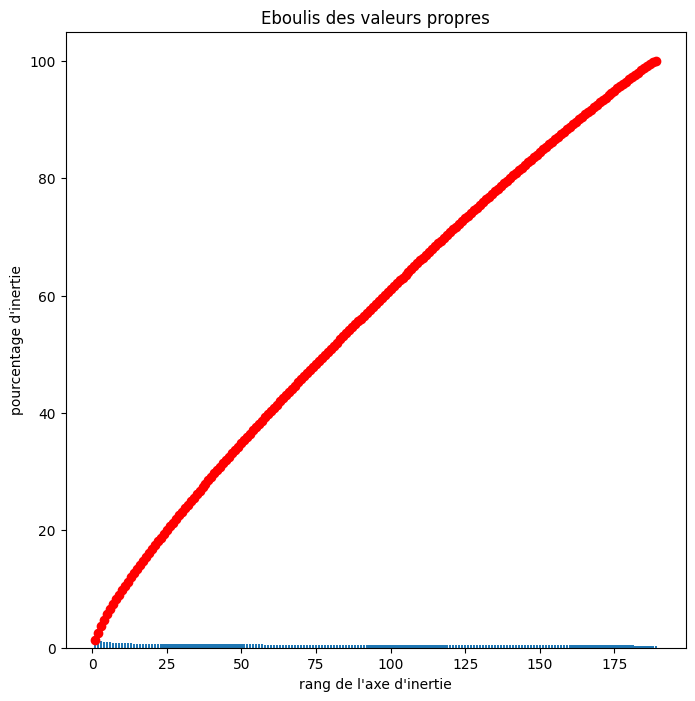


Nous conservons 140 composantes principales pour garder 80% d'inertie


In [26]:
X_train_tfidf_pca, X_test_tfidf_pca, pca_tfidf = pca_transformation(Xtfidf_train, Xtfidf_test)

## Vectorisation Word2Vec

In [27]:
w2v_size=200
w2v_window=8
w2v_min_count=1
w2v_epochs=100
maxlen = 30 # adapt to length of sentences

sentences_train = [gensim.utils.simple_preprocess(text) for text in X_train]
sentences_test = [gensim.utils.simple_preprocess(text) for text in X_test]

In [28]:

# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=multiprocessing.cpu_count() - 1)
w2v_model.build_vocab(sentences_train)
w2v_model.train(sentences_train, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 67642
Word2Vec trained


In [29]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
# Train set
train_token = Tokenizer()
train_token.fit_on_texts(sentences_train)
train_sentences = pad_sequences(train_token.texts_to_sequences(sentences_train),
                                maxlen=maxlen,
                                padding='post')
word_index_train = train_token.word_index
# Test set
test_token = Tokenizer()
test_token.fit_on_texts(sentences_test)
test_sentences = pad_sequences(test_token.texts_to_sequences(sentences_test),
                               maxlen=maxlen,
                               padding='post') 
word_index_test = test_token.word_index
print("Number of unique words: %i in training set" % len(word_index_train))
print("Number of unique words: %i in testing set" % len(word_index_test))

Fit Tokenizer ...
Number of unique words: 67642 in training set
Number of unique words: 35255 in testing set


## Création de la matrice d'embedding

In [30]:
# Création de la matrice d'embedding
print("Create Embedding matrix ...")
w2v_size = 200
vocab_size_train = len(word_index_train) + 1
vocab_size_test = len(word_index_test) + 1
embedding_matrix_train = np.zeros((vocab_size_train, w2v_size))
embedding_matrix_test = np.zeros((vocab_size_test, w2v_size))
i=0
j=0
    
for word, idx in word_index_train.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix_train[idx] = model_vectors[word]
i, j = 0, 0
for word, idx in word_index_test.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix_test[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix for Train : %s" % str(embedding_matrix_train.shape))
print("Embedding matrix for Test : %s" % str(embedding_matrix_test.shape))

Create Embedding matrix ...
Word embedding rate :  0.4392
Embedding matrix for Train : (67643, 200)
Embedding matrix for Test : (35256, 200)


## Création du modèle d'embedding

In [31]:
# Création du modèle

input=Input(shape=(len(train_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size_train,
                         output_dim=w2v_size,
                         weights = [embedding_matrix_train],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model_train = Model([word_input],word_vec)

embed_model_train.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 200)           13528600  
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 13,528,600
Trainable params: 13,528,600
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Création du modèle

input = Input(shape=(len(test_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size_test,
                         output_dim=w2v_size,
                         weights = [embedding_matrix_test],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model_test = Model([word_input],word_vec)

embed_model_test.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 200)           7051200   
                                                                 
 global_average_pooling1d_1   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 7,051,200
Trainable params: 7,051,200
Non-trainable params: 0
_________________________________________________________________


#### Exécution du modèle

In [33]:
Xw2v_train = embed_model_train.predict(train_sentences)
Xw2v_train.shape

804/804 [==============================] - 3s 3ms/step


(25702, 200)

In [34]:
Xw2v_test = embed_model_test.predict(test_sentences)
Xw2v_test.shape

345/345 [==============================] - 1s 3ms/step


(11016, 200)

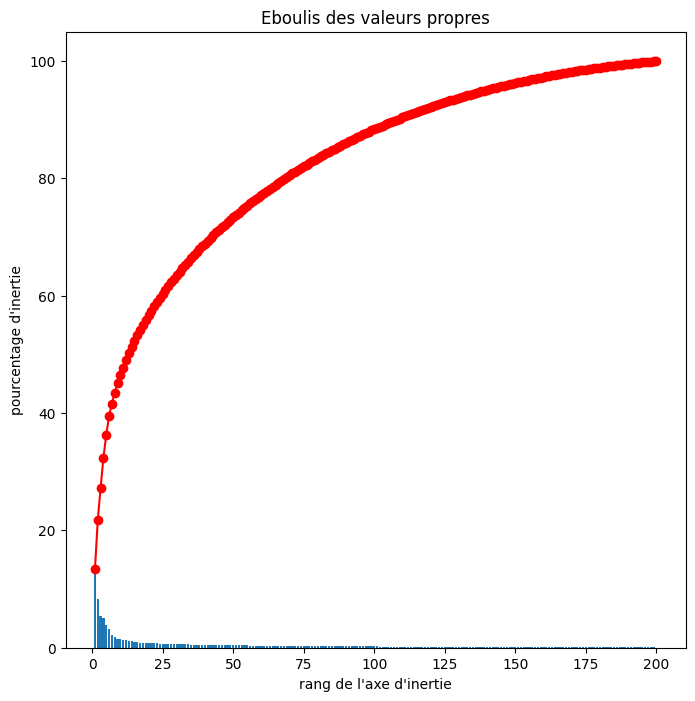


Nous conservons 69 composantes principales pour garder 80% d'inertie


In [35]:
X_train_w2v_pca, X_test_w2v_pca, pca_w2v = pca_transformation(Xw2v_train, Xw2v_test)

In [36]:
joblib.dump(w2v_model, open('../Models/embed_model_train.joblib', 'wb'), compress=True)

## Vectorisation de BERT

<b> BERT </b> ou <b> Bidirectional Encoder Representations from Transformers </b> c'est la Représentations d'encodeurs bidirectionnels à partir de transformateurs. Il apprend de facon non supervisée, l'entrée se suffit à elle même, autrement dit il n'a pas besoin qu'on lui fournisse de label, on se servira uniquement de l'entrée, et de plusieurs manières. Nous appellerons ça le MLM pour "Masked language model".

In [37]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(1 + len(sentences) // batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### 'bert-base-uncased'

In [38]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences_train = X_train
sentences_test = X_test

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [39]:
# Création des features
X_train_bert_hf, last_hidden_hf = feature_BERT_fct(model, model_type,
                                                   sentences_train, max_length,
                                                   batch_size, mode='HF')

1/1 [==============================] - 4s 4s/step
temps traitement :  5018.0


In [40]:
# Création des features
X_test_bert_hf, last_hidden_hf = feature_BERT_fct(model, model_type,
                                                   sentences_test, max_length,
                                                   batch_size, mode='HF')

1/1 [==============================] - 0s 425ms/step
temps traitement :  1338.0


In [41]:
joblib.dump(model, open('../Models/bert_model.joblib', 'wb'), compress=True)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...bert
......vars
...bert\embeddings
......vars
.........0
.........1
.........2
...bert\embeddings\LayerNorm
......vars
.........0
.........1
...bert\embeddings\dropout
......vars
...bert\encoder
......vars
...bert\encoder\layer\tf_bert_layer
......vars
...bert\encoder\layer\tf_bert_layer\attention
......vars
...bert\encoder\layer\tf_bert_layer\attention\dense_output
......vars
...bert\encoder\layer\tf_bert_layer\attention\dense_output\LayerNorm
......vars
.........0
.........1
...bert\encoder\layer\tf_bert_layer\attention\dense_output\dense
......vars
.........0
.........1
...bert\encoder\layer\tf_bert_layer\attention\dense_output\dropout
......vars
...bert\encoder\layer\tf_bert_layer\attention\self_attention
......vars
...bert\encoder\layer\tf_bert_layer\attention\self_attention\dropout
......vars
...bert\encoder\layer\tf_bert_layer\attention\self_attention\key
......vars
.........0
.........1
...bert\encoder\layer\t

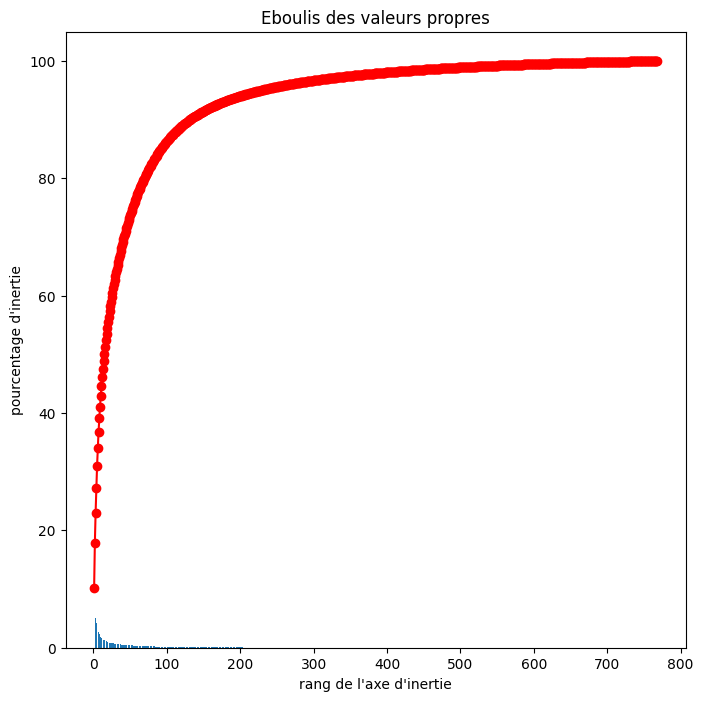


Nous conservons 70 composantes principales pour garder 80% d'inertie


In [42]:
X_train_bert_pca, X_test_bert_pca, pca_bert = pca_transformation(X_train_bert_hf, X_test_bert_hf)

## Vectorisation USE - Universal Sentence Encoder

In [43]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [44]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()
    
    for step in range(len(sentences) // batch_size + 1) :
        idx = step * batch_size
        feat = embed(sentences[idx : idx + batch_size])

        if step == 0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
            
    time2 = np.round(time.time() - time1,0)
    print("Temps d'execution : ", time2 )
    return features

In [45]:
batch_size = 10
X_train_use = feature_USE_fct(X_train, batch_size)
X_test_use = feature_USE_fct(X_test, batch_size)

Temps d'execution :  47.0
Temps d'execution :  14.0


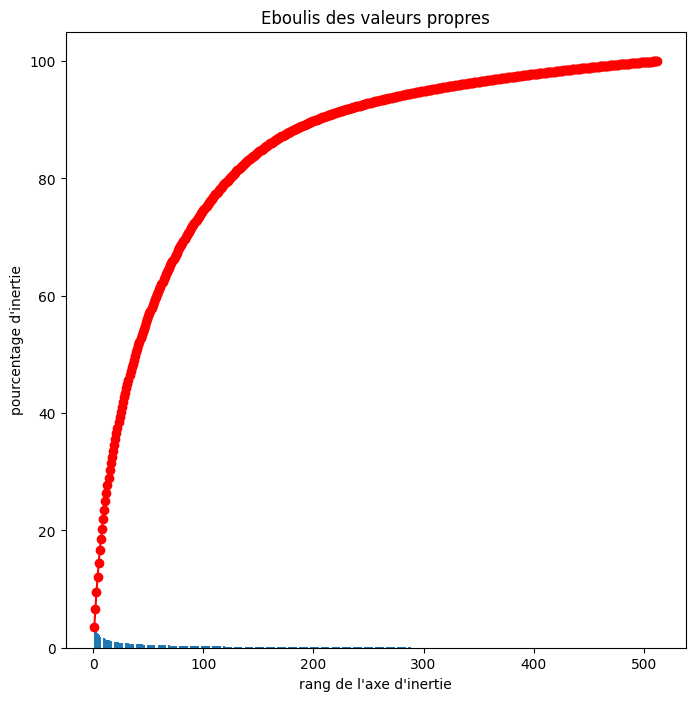


Nous conservons 124 composantes principales pour garder 80% d'inertie


In [46]:
X_train_use_pca, X_test_use_pca, pca_use = pca_transformation(X_train_use, X_test_use)

In [47]:
joblib.dump(Xtfidf_train, open('../Variables/X_train_tfidf.joblib', 'wb'), compress=True)
joblib.dump(Xtfidf_test, open('../Variables/X_test_tfidf.joblib', 'wb'), compress=True)

In [48]:
joblib.dump(Xw2v_train, open('../Variables/Xw2v_train.joblib', 'wb'), compress=True)
joblib.dump(Xw2v_test, open('../Variables/Xw2v_test.joblib', 'wb'), compress=True)

In [49]:
joblib.dump(X_train_bert_hf, open('../Variables/X_train_bert_hf.joblib', 'wb'),compress=True)
joblib.dump(X_test_bert_hf, open('../Variables/X_test_bert_hf.joblib', 'wb'), compress=True)

In [50]:
joblib.dump(X_train_use, open('../Variables/X_train_use.joblib', 'wb'), compress=True)
joblib.dump(X_test_use, open('../Variables/X_test_use.joblib', 'wb'), compress=True)